In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

In [2]:
picture_size = 32
folder_path = "images/"
batch_size = 32
epochs = 100
no_of_classes = 7

In [4]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

def preprocess_images(folder_path, picture_size, color_mode='grayscale'):
    print(f"Preprocessing images in: {folder_path}")
    
    if not os.path.exists(folder_path):
        print(f"Error: The path {folder_path} does not exist.")
        print(f"Current working directory: {os.getcwd()}")
        print(f"Contents of current directory: {os.listdir('.')}")
        raise FileNotFoundError(f"The path {folder_path} does not exist")
    
    images = []
    labels = []
    class_names = sorted([d for d in os.listdir(folder_path) if d != "disgust" and os.path.isdir(os.path.join(folder_path, d))])
    
    print(f"Found the following classes (excluding 'disgust'): {class_names}")
    

    total_images = sum(len(os.listdir(os.path.join(folder_path, class_name))) 
                       for class_name in class_names)
    

    pbar = tqdm(total=total_images, desc="Processing images")
    
    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path):
            continue
        
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size=(picture_size, picture_size), color_mode=color_mode)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(class_name)
            pbar.update(1)
    
    pbar.close()
    
    print("Converting to numpy array and normalizing...")
    images = np.array(images, dtype='float32') / 255.0
    
    print("Encoding labels...")
    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)
    labels_categorical = to_categorical(labels_encoded)
    
    return images, labels_categorical, le.classes_


folder_path = "images"
picture_size = 32
train_path = os.path.join(folder_path, "train")
X_train, y_train, class_names = preprocess_images(train_path, picture_size)
val_path = os.path.join(folder_path, "validation")
X_val, y_val, _ = preprocess_images(val_path, picture_size)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

Preprocessing images in: images\train
Found the following classes (excluding 'disgust'): ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']



Processing images:  34%|███▎      | 9529/28385 [00:27<03:31, 89.15it/s]


Processing images:  41%|████      | 11539/28385 [00:51<03:45, 74.59it/s]


Processing images:  48%|████▊     | 13648/28385 [01:15<03:48, 64.40it/s]


Processing images:  54%|█████▍    | 15288/28385 [01:40<03:22, 64.56it/s]


Processing images:  61%|██████    | 17310/28385 [02:04<02:05, 88.26it/s]


Processing images:  68%|██████▊   | 19417/28385 [02:28<01:46, 84.01it/s]


Processing images:  76%|███████▌  | 21622/28385 [02:52<01:29, 75.81it/s]


Processing images:  83%|████████▎ | 23525/28385 [03:16<01:08, 70.48it/s]


Processing images:  89%|████████▉ | 25360/28385 [03:40<00:47, 63.90it/s]


Processing images:  96%|█████████▌| 27113/28385 [04:04<00:15, 80.49it/s]


Processing images: 100%|██████████| 28385/28385 [04:18<00:00, 109.91it/s][A


Converting to numpy array and normalizing...
Encoding labels...
Preprocessing images in: images\validation
Found the following classes (excluding 'disgust'): ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']



Processing images:  30%|███       | 2105/6955 [00:25<00:50, 96.82it/s]


Processing images:  61%|██████▏   | 4275/6955 [00:49<00:31, 85.34it/s]


Processing images:  87%|████████▋ | 6044/6955 [01:14<00:13, 65.26it/s]


Processing images: 100%|██████████| 6955/6955 [01:26<00:00, 80.05it/s]

Converting to numpy array and normalizing...
Encoding labels...
Training data shape: (28385, 32, 32, 1)
Training labels shape: (28385, 6)
Validation data shape: (6955, 32, 32, 1)
Validation labels shape: (6955, 6)
Number of classes: 6
Class names: ['angry' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def create_improved_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3,3), padding='same', input_shape=input_shape, kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.3),
        
        Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.3),
        
        Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.4),
        
        Flatten(),
        Dense(256, kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        
        Dense(num_classes, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

model = create_improved_model(input_shape, num_classes)



C:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  
    batch_size=32,  
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/100
888/888 ━━━━━━━━━━━━━━━━━━━━ 53s 52ms/step - accuracy: 0.2545 - loss: 2.0339 - val_accuracy: 0.3817 - val_loss: 1.6773 - learning_rate: 0.0010
Epoch 2/100
888/888 ━━━━━━━━━━━━━━━━━━━━ 47s 53ms/step - accuracy: 0.3768 - loss: 1.6261 - val_accuracy: 0.4316 - val_loss: 1.5323 - learning_rate: 0.0010
Epoch 3/100
888/888 ━━━━━━━━━━━━━━━━━━━━ 48s 54ms/step - accuracy: 0.4236 - loss: 1.5420 - val_accuracy: 0.4663 - val_loss: 1.4342 - learning_rate: 0.0010
Epoch 4/100
888/888 ━━━━━━━━━━━━━━━━━━━━ 45s 51ms/step - accuracy: 0.4498 - loss: 1.4928 - val_accuracy: 0.4679 - val_loss: 1.4425 - learning_rate: 0.0010
Epoch 5/100
888/888 ━━━━━━━━━━━━━━━━━━━━ 47s 53ms/step - accuracy: 0.4649 - loss: 1.4710 - val_accuracy: 0.4985 - val_loss: 1.3984 - learning_rate: 0.0010
Epoch 6/100
888/888 ━━━━━━━━━━━━━━━━━━━━ 48s 54ms/step - accuracy: 0.4806 - loss: 1.4505 - val_accuracy: 0.4749 - val_loss: 1.4516 - learning_rate: 0.0010
Epoch 7/100
888/888 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.4

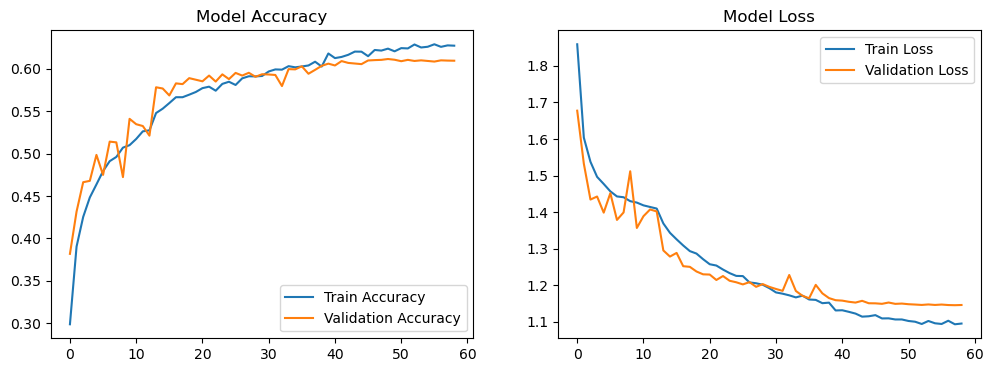

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()